#  Combined All-Well Analysis

### This notebook performs a comprehensive analysis across all wells to identify consistent patterns and correlations between log and lab measurements.


#  Import Libraries and Setup


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
import missingno as msno
from Module import *
warnings.filterwarnings('ignore')

# plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directory for plots
Path('imgs').mkdir(exist_ok=True)

# Define well colors for consistent visualization
well_colors = {
    'HRDH_697': '#d62728',
    'HRDH_1119': '#1f77b4',
    'HRDH_1804': '#ff7f0e',
    'HRDH_1867': '#2ca02c',

}


#  Data Loading and Preparation


In [19]:
# Load all well data
print("Loading data from all wells...")
df_all = load_all_wells_csv()  # Assuming this function exists in Module.py

# Display basic information
print(f"\nDataset shape: {df_all.shape}")
print(f"Wells included: {df_all['Well'].unique()}")
print(f"\nSamples per well:")
print(df_all['Well'].value_counts().sort_index())


Loading data from all wells...
Found 4 joined CSV files:
HRDH_1119\HRDH_1119_joined.csv
HRDH_1804\HRDH_1804_joined.csv
HRDH_1867\HRDH_1867_joined.csv
HRDH_697\HRDH_697_joined.csv
Loaded HRDH_1119: 18 samples, 73 columns
Loaded HRDH_1804: 41 samples, 56 columns
Loaded HRDH_1867: 9 samples, 59 columns
Loaded HRDH_697: 10 samples, 66 columns

Combined dataset: 78 total samples from 4 wells
Wells: HRDH_1119, HRDH_1804, HRDH_1867, HRDH_697
Sample distribution by well:
Well
HRDH_1804    41
HRDH_1119    18
HRDH_697     10
HRDH_1867     9

Dataset shape: (78, 89)
Wells included: ['HRDH_1119', 'HRDH_1804', 'HRDH_1867', 'HRDH_697']
Categories (4, object): ['HRDH_1119', 'HRDH_1804', 'HRDH_1867', 'HRDH_697']

Samples per well:
Well
HRDH_1119    18
HRDH_1804    41
HRDH_1867     9
HRDH_697     10
Name: count, dtype: int64


#  Data Overview and Column Classification


In [20]:

# Only include specific log measurements
specific_logs = ['CN', 'CNC', 'GR', 'GRSL', 'HRD1', 'HRD2', 'K', 'KTH', 'LSN', 
                'PE', 'QPKS', 'SFT2', 'SHR', 'SLTM', 'ZDNC']

# Convert to Log_ prefixed names
specific_log_columns = [f'Log_{log}' for log in specific_logs]

# Filter columns
lab_columns = [col for col in df_all.columns if col.startswith('Lab_') and col != 'Lab_Depth' and col != 'Lab_Sample_ID']

# Only include log columns that are in the specific list
all_log_columns = [col for col in df_all.columns if col.startswith('Log_') and col != 'Log_Depth' and col != 'Log_FRAMENO']
log_columns = [col for col in all_log_columns if col in specific_log_columns]

# Check which specific logs are missing
available_logs = [col.replace('Log_', '') for col in log_columns]
missing_logs = [log for log in specific_logs if log not in available_logs]

metadata_columns = ['Lab_Depth', 'Log_Depth', 'Distance', 'Match_Type', 'Well']

# Remove Sample_ID and FRAMENO columns if they exist
columns_to_exclude = ['Lab_Sample_ID', 'Log_FRAMENO', 'Sample_ID', 'FRAMENO']

for col in columns_to_exclude:
    if col in df_all.columns:
        print(f"Excluding column: {col}")
        df_all = df_all.drop(columns=[col])

print(f"Column Classification:")
print(f"Lab measurements: {len(lab_columns)}")
print(f"Log measurements (filtered): {len(log_columns)} out of {len(specific_logs)} requested")
print(f"Available logs: {', '.join(available_logs)}")

if missing_logs:
    print(f"  - Missing logs: {', '.join(missing_logs)}")
print(f"Metadata: {len(metadata_columns)}")
print(f"Total columns: {len(df_all.columns)}")

# Display sample counts per well
print("\nSamples per well:")
print(df_all['Well'].value_counts().sort_index())



Excluding column: Lab_Sample_ID
Excluding column: Log_FRAMENO
Column Classification:
Lab measurements: 35
Log measurements (filtered): 15 out of 15 requested
Available logs: CN, CNC, GR, GRSL, HRD1, HRD2, K, KTH, LSN, PE, QPKS, SFT2, SHR, SLTM, ZDNC
Metadata: 5
Total columns: 87

Samples per well:
Well
HRDH_1119    18
HRDH_1804    41
HRDH_1867     9
HRDH_697     10
Name: count, dtype: int64


#  Missing Data Analysis


In [21]:
# Calculate missing data summary
missing_summary = pd.DataFrame({
    'Missing_Count': df_all.isnull().sum(),
    'Missing_Percent': (df_all.isnull().sum() / len(df_all)) * 100
}).sort_values('Missing_Percent', ascending=False)

# Identify columns with high missing data
high_missing = missing_summary[missing_summary['Missing_Percent'] > 50]

print("Top 10 columns with most missing data:")
print(missing_summary.head(10))
print(f"\nColumns with >50% missing data: {len(high_missing)}")

Top 10 columns with most missing data:
                Missing_Count  Missing_Percent
Log_CNL                    69        88.461538
Lab_XRD_Halite             69        88.461538
Log_CHT.I                  68        87.179487
Log_CALZ                   60        76.923077
Log_CVOL                   51        65.384615
Log_BVOL                   51        65.384615
Log_CHT                    51        65.384615
Lab_XRF_Ti                 50        64.102564
Lab_XRF_Mn                 50        64.102564
Lab_XRF_Fe                 50        64.102564

Columns with >50% missing data: 33


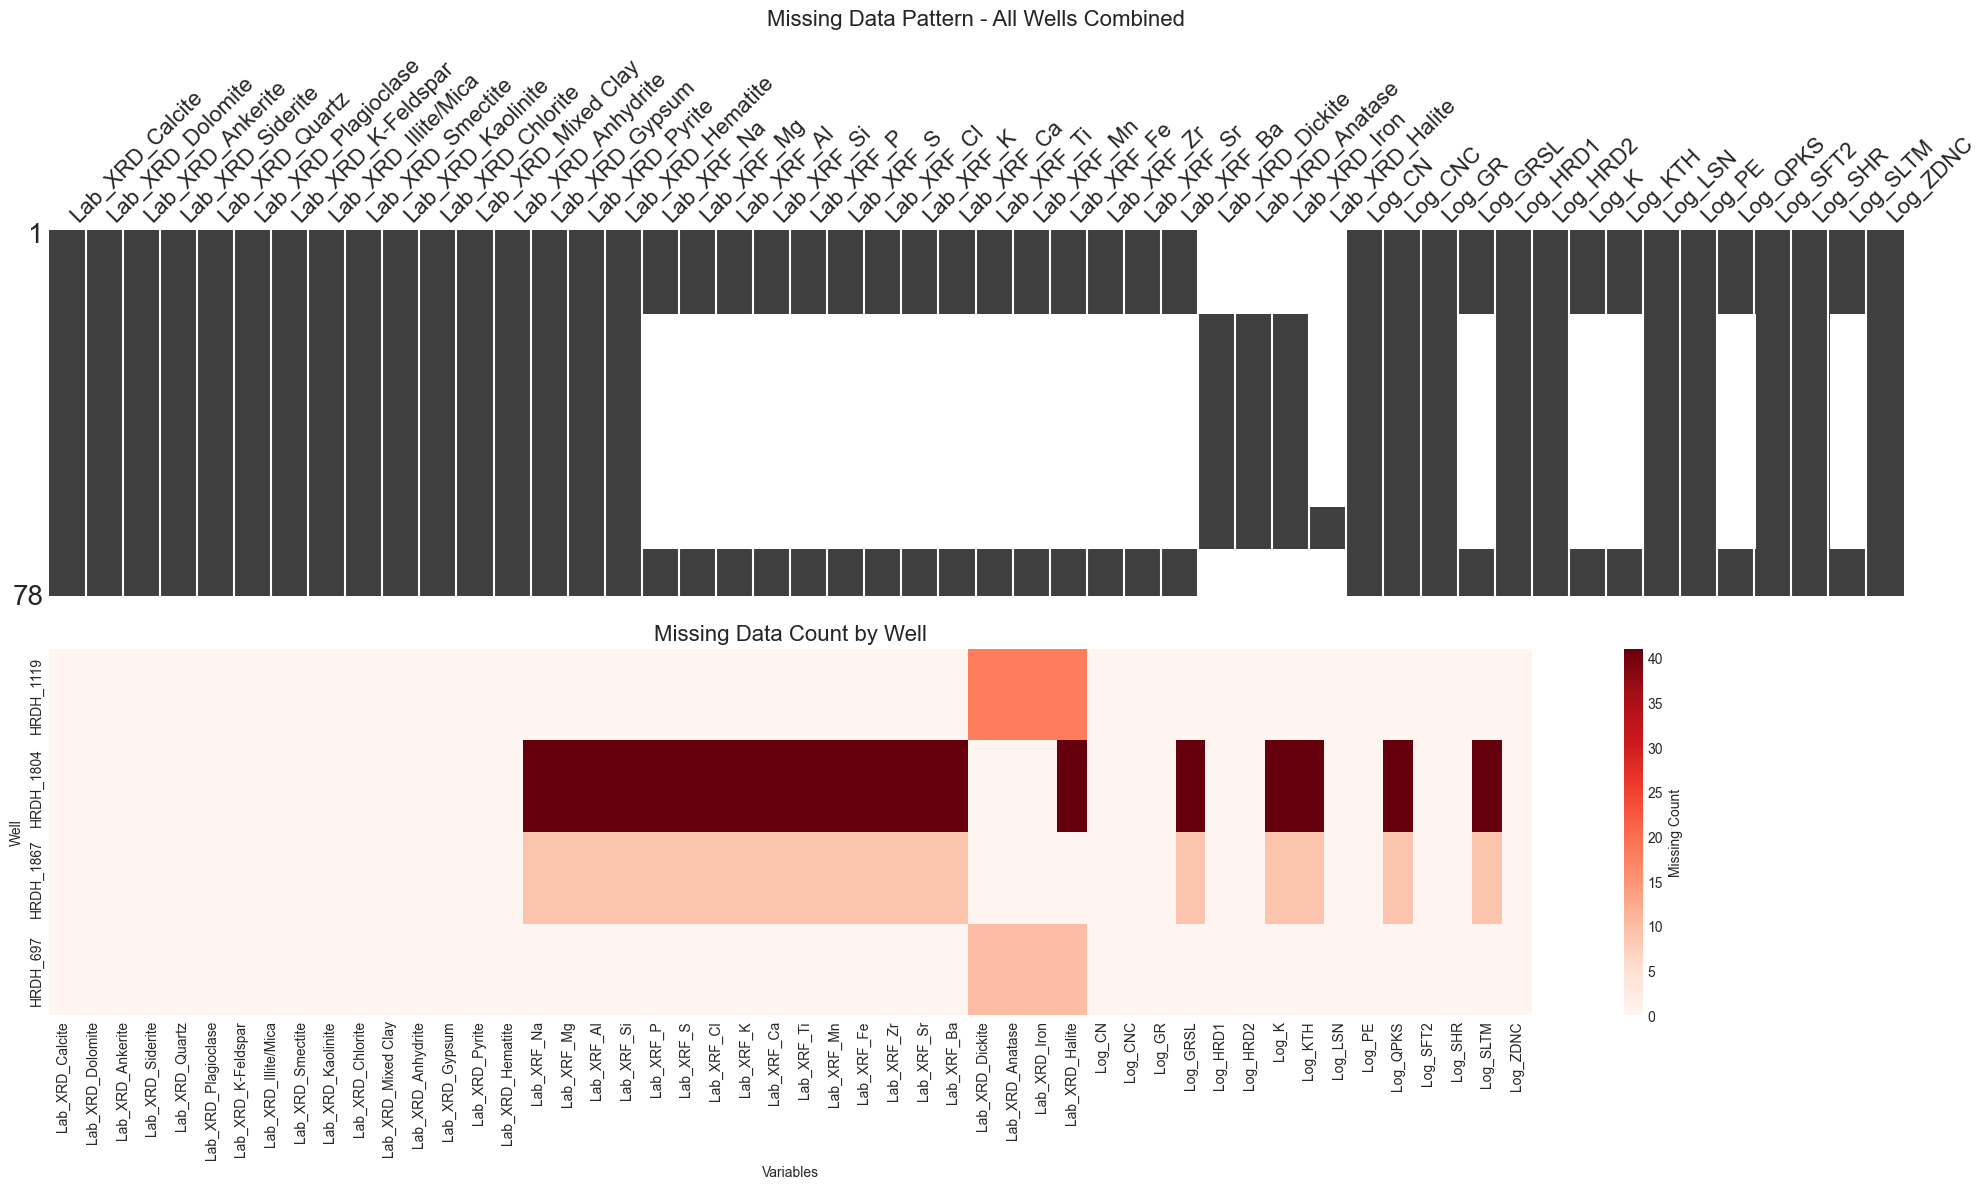

In [22]:
# Visualize missing data patterns
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Missing data matrix
ax1 = axes[0]
msno.matrix(df_all[lab_columns + log_columns], ax=ax1, sparkline=False)
ax1.set_title('Missing Data Pattern - All Wells Combined', fontsize=16, pad=20)

# Missing data heatmap
ax2 = axes[1]
missing_by_well = df_all.groupby('Well')[lab_columns + log_columns].apply(lambda x: x.isnull().sum())
sns.heatmap(missing_by_well, cmap='Reds', ax=ax2, cbar_kws={'label': 'Missing Count'})
ax2.set_title('Missing Data Count by Well', fontsize=16)
ax2.set_xlabel('Variables')
ax2.set_ylabel('Well')

plt.tight_layout()
plt.savefig('imgs/missing_data_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

#  Correlation Analysis Across Wells


In [23]:
def calculate_correlations_by_well(df, lab_vars, log_vars, min_samples=10):
    """Calculate correlations for each well separately"""
    well_correlations = {}
    
    for well in df['Well'].unique():
        well_data = df[df['Well'] == well]
        
        # Initialize correlation matrix
        corr_matrix = pd.DataFrame(index=log_vars, columns=lab_vars, dtype=float)
        
        # Calculate correlations for each pair
        for log_var in log_vars:
            for lab_var in lab_vars:
                # Get clean data pairs
                clean_data = well_data[[log_var, lab_var]].dropna()
                
                if len(clean_data) >= min_samples:
                    corr, p_val = stats.pearsonr(clean_data[log_var], clean_data[lab_var])
                    corr_matrix.loc[log_var, lab_var] = corr
                else:
                    corr_matrix.loc[log_var, lab_var] = np.nan
        
        well_correlations[well] = corr_matrix
    
    return well_correlations

# Calculate correlations for each well
print("Calculating correlations for each well...")
well_correlations = calculate_correlations_by_well(df_all, lab_columns, log_columns)
well_correlations

Calculating correlations for each well...


{'HRDH_1119':           Lab_XRD_Calcite  Lab_XRD_Dolomite  Lab_XRD_Ankerite  \
 Log_CN           0.066035          0.585675               NaN   
 Log_CNC          0.060789          0.589637               NaN   
 Log_GR           0.651625          0.422431               NaN   
 Log_GRSL         0.651419          0.421838               NaN   
 Log_HRD1         0.542255          0.581833               NaN   
 Log_HRD2         0.597141          0.576661               NaN   
 Log_K            0.337700          0.347373               NaN   
 Log_KTH          0.566349          0.342604               NaN   
 Log_LSN         -0.247765         -0.683837               NaN   
 Log_PE           0.477848          0.631144               NaN   
 Log_QPKS              NaN               NaN               NaN   
 Log_SFT2         0.433125          0.494642               NaN   
 Log_SHR         -0.488486         -0.660559               NaN   
 Log_SLTM         0.364886          0.204126               NaN 

#  Find Common Significant Correlations


In [24]:
def find_common_correlations(well_correlations, min_correlation=0.5, min_wells=2, total_wells=4):
    """
    Find variable pairs that are correlated in multiple wells with enhanced reporting.
    
    Parameters:
    -----------
    well_correlations : dict
        Dictionary of correlation matrices by well
    min_correlation : float
        Minimum absolute correlation value to consider
    min_wells : int
        Minimum number of wells where correlation must be present
    total_wells : int
        Total number of wells in the dataset
    
    Returns:
    --------
    list of tuples: (pair, wells_data, correlation_info)
    """
    
    # Track correlations across wells
    correlation_tracker = {}
    all_wells = list(well_correlations.keys())
    
    # Find correlations in each well
    for well, corr_matrix in well_correlations.items():
        for log_var in corr_matrix.index:
            for lab_var in corr_matrix.columns:
                r = corr_matrix.loc[log_var, lab_var]
                
                # If correlation is strong enough
                if not pd.isna(r) and abs(r) >= min_correlation:
                    pair = (log_var, lab_var)
                    if pair not in correlation_tracker:
                        correlation_tracker[pair] = {
                            'wells_data': [],
                            'missing_wells': [],
                            'all_correlations': {}
                        }
                    correlation_tracker[pair]['wells_data'].append((well, r))
                    correlation_tracker[pair]['all_correlations'][well] = r
    
    # Analyze each correlation pair
    common_correlations = []
    for pair, data in correlation_tracker.items():
        wells_data = data['wells_data']
        
        if len(wells_data) >= min_wells:
            # Find which wells are missing this correlation
            wells_with_corr = [well for well, _ in wells_data]
            missing_wells = [well for well in all_wells if well not in wells_with_corr]
            
            # Calculate statistics
            correlations = [r for _, r in wells_data]
            avg_corr = np.mean(correlations)
            avg_abs_corr = np.mean([abs(r) for r in correlations])
            std_corr = np.std(correlations)
            
            # Check if correlations are consistent in direction
            all_positive = all(r > 0 for r in correlations)
            all_negative = all(r < 0 for r in correlations)
            consistent_direction = all_positive or all_negative
            
            correlation_info = {
                'pair': pair,
                'wells_data': wells_data,
                'n_wells': len(wells_data),
                'total_wells': total_wells,
                'missing_wells': missing_wells,
                'avg_corr': avg_corr,
                'avg_abs_corr': avg_abs_corr,
                'std_corr': std_corr,
                'consistent_direction': consistent_direction,
                'correlation_type': 'positive' if avg_corr > 0 else 'negative'
            }
            
            common_correlations.append((pair, wells_data, correlation_info))
    
    # Sort by average absolute correlation strength
    common_correlations.sort(key=lambda x: x[2]['avg_abs_corr'], reverse=True)
    
    return common_correlations

In [25]:
def print_correlation_summary(common_correlations, top_n=10):
    """
    Print a detailed summary of common correlations with well coverage information.
    """
    print("\n" + "="*100)
    print("DETAILED CORRELATION SUMMARY")
    print("="*100)
    
    if not common_correlations:
        print("No common correlations found.")
        return
    
    print(f"\nTotal correlation pairs found: {len(common_correlations)}")
    
    # Group by number of wells
    well_coverage = {}
    for _, _, info in common_correlations:
        n_wells = info['n_wells']
        if n_wells not in well_coverage:
            well_coverage[n_wells] = 0
        well_coverage[n_wells] += 1
    
    print("\nCoverage Distribution:")
    for n_wells in sorted(well_coverage.keys(), reverse=True):
        total_wells = common_correlations[0][2]['total_wells'] if common_correlations else 4
        percentage = (n_wells / total_wells) * 100
        print(f"  - {n_wells}/{total_wells} wells ({percentage:.0f}%): {well_coverage[n_wells]} pairs")
    
    # Consistency analysis
    consistent_pairs = sum(1 for _, _, info in common_correlations if info['consistent_direction'])
    print(f"\nDirection Consistency:")
    print(f"  - Consistent direction: {consistent_pairs} pairs ({consistent_pairs/len(common_correlations)*100:.1f}%)")
    print(f"  - Mixed direction: {len(common_correlations) - consistent_pairs} pairs")
    
    print(f"\nTop {min(top_n, len(common_correlations))} Correlations (by absolute strength):")
    print("-" * 100)
    
    for i, (pair, wells_data, info) in enumerate(common_correlations[:top_n]):
        log_var, lab_var = pair
        
        print(f"\n{i+1}. {log_var.replace('Log_', '')} vs {lab_var.replace('Lab_', '')}")
        print(f"   Coverage: {info['n_wells']}/{info['total_wells']} wells ({info['n_wells']/info['total_wells']*100:.0f}%)")
        print(f"   Average |r|: {info['avg_abs_corr']:.3f} (σ = {info['std_corr']:.3f})")
        print(f"   Type: {info['correlation_type'].capitalize()} correlation")
        print(f"   Direction: {'Consistent' if info['consistent_direction'] else 'Mixed'}")
        
        # Show individual well correlations
        print(f"   Well correlations:")
        for well, r in sorted(wells_data, key=lambda x: abs(x[1]), reverse=True):
            print(f"     - {well}: r = {r:.3f}")
        
        # Show missing wells
        if info['missing_wells']:
            print(f"   Missing from: {', '.join(info['missing_wells'])}")
            
            

# Calculate correlations with enhanced function
common_correlations = find_common_correlations(
    well_correlations, 
    min_correlation=0.5, 
    min_wells=2,
    total_wells=df_all['Well'].nunique()
)

# Print detailed summary
print_correlation_summary(common_correlations, top_n=15)

#

# Find correlations present in ALL wells
correlations_all_wells = [
    (pair, wells_data, info) 
    for pair, wells_data, info in common_correlations 
    if info['n_wells'] == info['total_wells']
]

total_wells = df_all['Well'].nunique()
print(f"\n\nCorrelations present in ALL {total_wells} wells: {len(correlations_all_wells)}")
if correlations_all_wells:
    print_correlation_summary(correlations_all_wells, top_n=10)


DETAILED CORRELATION SUMMARY

Total correlation pairs found: 15

Coverage Distribution:
  - 2/4 wells (50%): 15 pairs

Direction Consistency:
  - Consistent direction: 11 pairs (73.3%)
  - Mixed direction: 4 pairs

Top 15 Correlations (by absolute strength):
----------------------------------------------------------------------------------------------------

1. SHR vs XRF_Sr
   Coverage: 2/4 wells (50%)
   Average |r|: 0.691 (σ = 0.139)
   Type: Positive correlation
   Direction: Consistent
   Well correlations:
     - HRDH_697: r = 0.830
     - HRDH_1119: r = 0.552
   Missing from: HRDH_1804, HRDH_1867

2. PE vs XRF_Sr
   Coverage: 2/4 wells (50%)
   Average |r|: 0.689 (σ = 0.129)
   Type: Negative correlation
   Direction: Consistent
   Well correlations:
     - HRDH_697: r = -0.818
     - HRDH_1119: r = -0.560
   Missing from: HRDH_1804, HRDH_1867

3. LSN vs XRF_Cl
   Coverage: 2/4 wells (50%)
   Average |r|: 0.663 (σ = 0.108)
   Type: Negative correlation
   Direction: Consistent


In [26]:
print("="*80)
print("CORRELATION DISTRIBUTION ANALYSIS")
print("="*80)

# Set analysis parameters
min_wells = 2
total_wells = 4

# Check different correlation thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

print(f"Analyzing correlations at different thresholds (min_wells={min_wells}):")

for threshold in thresholds:
    correlations_at_thresh = find_common_correlations(
        well_correlations, min_correlation=threshold, min_wells=min_wells
    )
    print(f"  |r| ≥ {threshold}: {len(correlations_at_thresh)} correlations")

# Find correlations present in 3+ wells with lower threshold
print("\n" + "="*80)
print("CORRELATIONS IN 3+ WELLS (with lower threshold)")
print("="*80)

common_correlations_3wells = find_common_correlations(
    well_correlations, min_correlation=0.3, min_wells=3
)
print(f"\nFound {len(common_correlations_3wells)} variable pairs with |r| ≥ 0.3 in at least 3 wells")

if len(common_correlations_3wells) > 0:
    print("\nTop correlations in 3+ wells:")
    for i, (pair, wells_data, info) in enumerate(common_correlations_3wells[:10]):
        log_var, lab_var = pair
        avg_abs_corr = info['avg_abs_corr']
        n_wells = info['n_wells']
        
        print(f"\n{i+1}. {log_var} vs {lab_var}")
        print(f"   Average |r| = {avg_abs_corr:.3f}, Found in {n_wells}/{total_wells} wells")
        wells_str = ", ".join([f"{well}(r={r:.3f})" for well, r in wells_data])
        print(f"   Wells: {wells_str}")

# Find correlations present in ALL 4 wells
print("\n" + "="*80)
print("CORRELATIONS IN ALL 4 WELLS")
print("="*80)

common_correlations_all = find_common_correlations(
    well_correlations, min_correlation=0.2, min_wells=4
)
print(f"\nFound {len(common_correlations_all)} variable pairs with |r| ≥ 0.2 in all 4 wells")

if len(common_correlations_all) > 0:
    print("\nCorrelations present in all wells:")
    for i, (pair, wells_data, info) in enumerate(common_correlations_all[:10]):
        log_var, lab_var = pair
        avg_abs_corr = info['avg_abs_corr']
        n_wells = info['n_wells']
        
        print(f"\n{i+1}. {log_var} vs {lab_var}")
        print(f"   Average |r| = {avg_abs_corr:.3f}")
        wells_str = ", ".join([f"{well}(r={r:.3f})" for well, r in wells_data])
        print(f"   Wells: {wells_str}")
else:
    print("No correlations found in all 4 wells at |r| ≥ 0.2")

CORRELATION DISTRIBUTION ANALYSIS
Analyzing correlations at different thresholds (min_wells=2):
  |r| ≥ 0.3: 79 correlations
  |r| ≥ 0.4: 48 correlations
  |r| ≥ 0.5: 15 correlations
  |r| ≥ 0.6: 1 correlations
  |r| ≥ 0.7: 0 correlations

CORRELATIONS IN 3+ WELLS (with lower threshold)

Found 4 variable pairs with |r| ≥ 0.3 in at least 3 wells

Top correlations in 3+ wells:

1. Log_LSN vs Lab_XRD_Quartz
   Average |r| = 0.554, Found in 3/4 wells
   Wells: HRDH_1119(r=-0.390), HRDH_1804(r=0.513), HRDH_697(r=0.757)

2. Log_SFT2 vs Lab_XRD_Quartz
   Average |r| = 0.473, Found in 3/4 wells
   Wells: HRDH_1119(r=0.608), HRDH_1804(r=-0.440), HRDH_697(r=-0.373)

3. Log_HRD1 vs Lab_XRD_Quartz
   Average |r| = 0.472, Found in 3/4 wells
   Wells: HRDH_1119(r=0.517), HRDH_1804(r=-0.441), HRDH_697(r=-0.457)

4. Log_HRD2 vs Lab_XRD_Quartz
   Average |r| = 0.422, Found in 3/4 wells
   Wells: HRDH_1119(r=0.505), HRDH_1804(r=-0.433), HRDH_697(r=-0.327)

CORRELATIONS IN ALL 4 WELLS

Found 0 variable p

In [27]:
def find_common_correlations(well_correlations, min_correlation=0.5, min_wells=2):
    """Find variable pairs that are significantly correlated in multiple wells"""
    
    # Track correlations across wells
    correlation_tracker = {}
    
    for well, corr_matrix in well_correlations.items():
        for log_var in corr_matrix.index:
            for lab_var in corr_matrix.columns:
                r = corr_matrix.loc[log_var, lab_var]
                
                if not pd.isna(r) and abs(r) >= min_correlation:
                    pair = (log_var, lab_var)
                    if pair not in correlation_tracker:
                        correlation_tracker[pair] = []
                    correlation_tracker[pair].append((well, r))
    
    # Filter pairs that appear in enough wells
    common_correlations = []
    for pair, wells_data in correlation_tracker.items():
        if len(wells_data) >= min_wells:
            avg_corr = np.mean([abs(r) for _, r in wells_data])
            common_correlations.append((pair, wells_data, avg_corr))
    
    # Sort by average correlation strength
    common_correlations.sort(key=lambda x: x[2], reverse=True)
    
    return [(pair, wells_data) for pair, wells_data, _ in common_correlations]

# Find common correlations
common_correlations = find_common_correlations(well_correlations, min_correlation=0.5, min_wells=2)

print(f"\nFound {len(common_correlations)} variable pairs with |r| ≥ 0.5 in at least 2 wells")
print("\nTop 10 common correlations:")
for i, (pair, wells_data) in enumerate(common_correlations[:30]):
    log_var, lab_var = pair
    wells_str = ", ".join([f"{well}(r={r:.3f})" for well, r in wells_data])
    print(f"{i+1}. {log_var} vs {lab_var}: {wells_str}")


Found 15 variable pairs with |r| ≥ 0.5 in at least 2 wells

Top 10 common correlations:
1. Log_SHR vs Lab_XRF_Sr: HRDH_1119(r=0.552), HRDH_697(r=0.830)
2. Log_PE vs Lab_XRF_Sr: HRDH_1119(r=-0.560), HRDH_697(r=-0.818)
3. Log_LSN vs Lab_XRF_Cl: HRDH_1119(r=-0.555), HRDH_697(r=-0.772)
4. Log_PE vs Lab_XRF_Fe: HRDH_1119(r=0.507), HRDH_697(r=-0.797)
5. Log_LSN vs Lab_XRD_Quartz: HRDH_1804(r=0.513), HRDH_697(r=0.757)
6. Log_SFT2 vs Lab_XRF_Si: HRDH_1119(r=0.634), HRDH_697(r=-0.613)
7. Log_CN vs Lab_XRD_Quartz: HRDH_1804(r=-0.527), HRDH_697(r=-0.707)
8. Log_CNC vs Lab_XRD_Quartz: HRDH_1804(r=-0.513), HRDH_697(r=-0.707)
9. Log_KTH vs Lab_XRF_Na: HRDH_1119(r=0.551), HRDH_697(r=0.665)
10. Log_SFT2 vs Lab_XRF_K: HRDH_1119(r=0.560), HRDH_697(r=0.608)
11. Log_SFT2 vs Lab_XRF_Al: HRDH_1119(r=0.605), HRDH_697(r=0.559)
12. Log_HRD1 vs Lab_XRF_Al: HRDH_1119(r=0.514), HRDH_697(r=0.634)
13. Log_SFT2 vs Lab_XRF_Fe: HRDH_1119(r=0.580), HRDH_697(r=0.557)
14. Log_HRD1 vs Lab_XRF_Si: HRDH_1119(r=0.527), HRDH

# Visualize Common Correlations - Combined Scatter Plots


Enhanced Scatter Plot Analysis

Well Color Assignments:
----------------------------------------
  HRDH_1119       : #2E86AB ■
  HRDH_1804       : #F77F00 ■
  HRDH_1867       : #06D6A0 ■
  HRDH_697        : #E63946 ■
----------------------------------------

Separating correlations by sign:
  - Positive correlations: 9
  - Negative correlations: 6

Creating plot for 9 POSITIVE correlations...


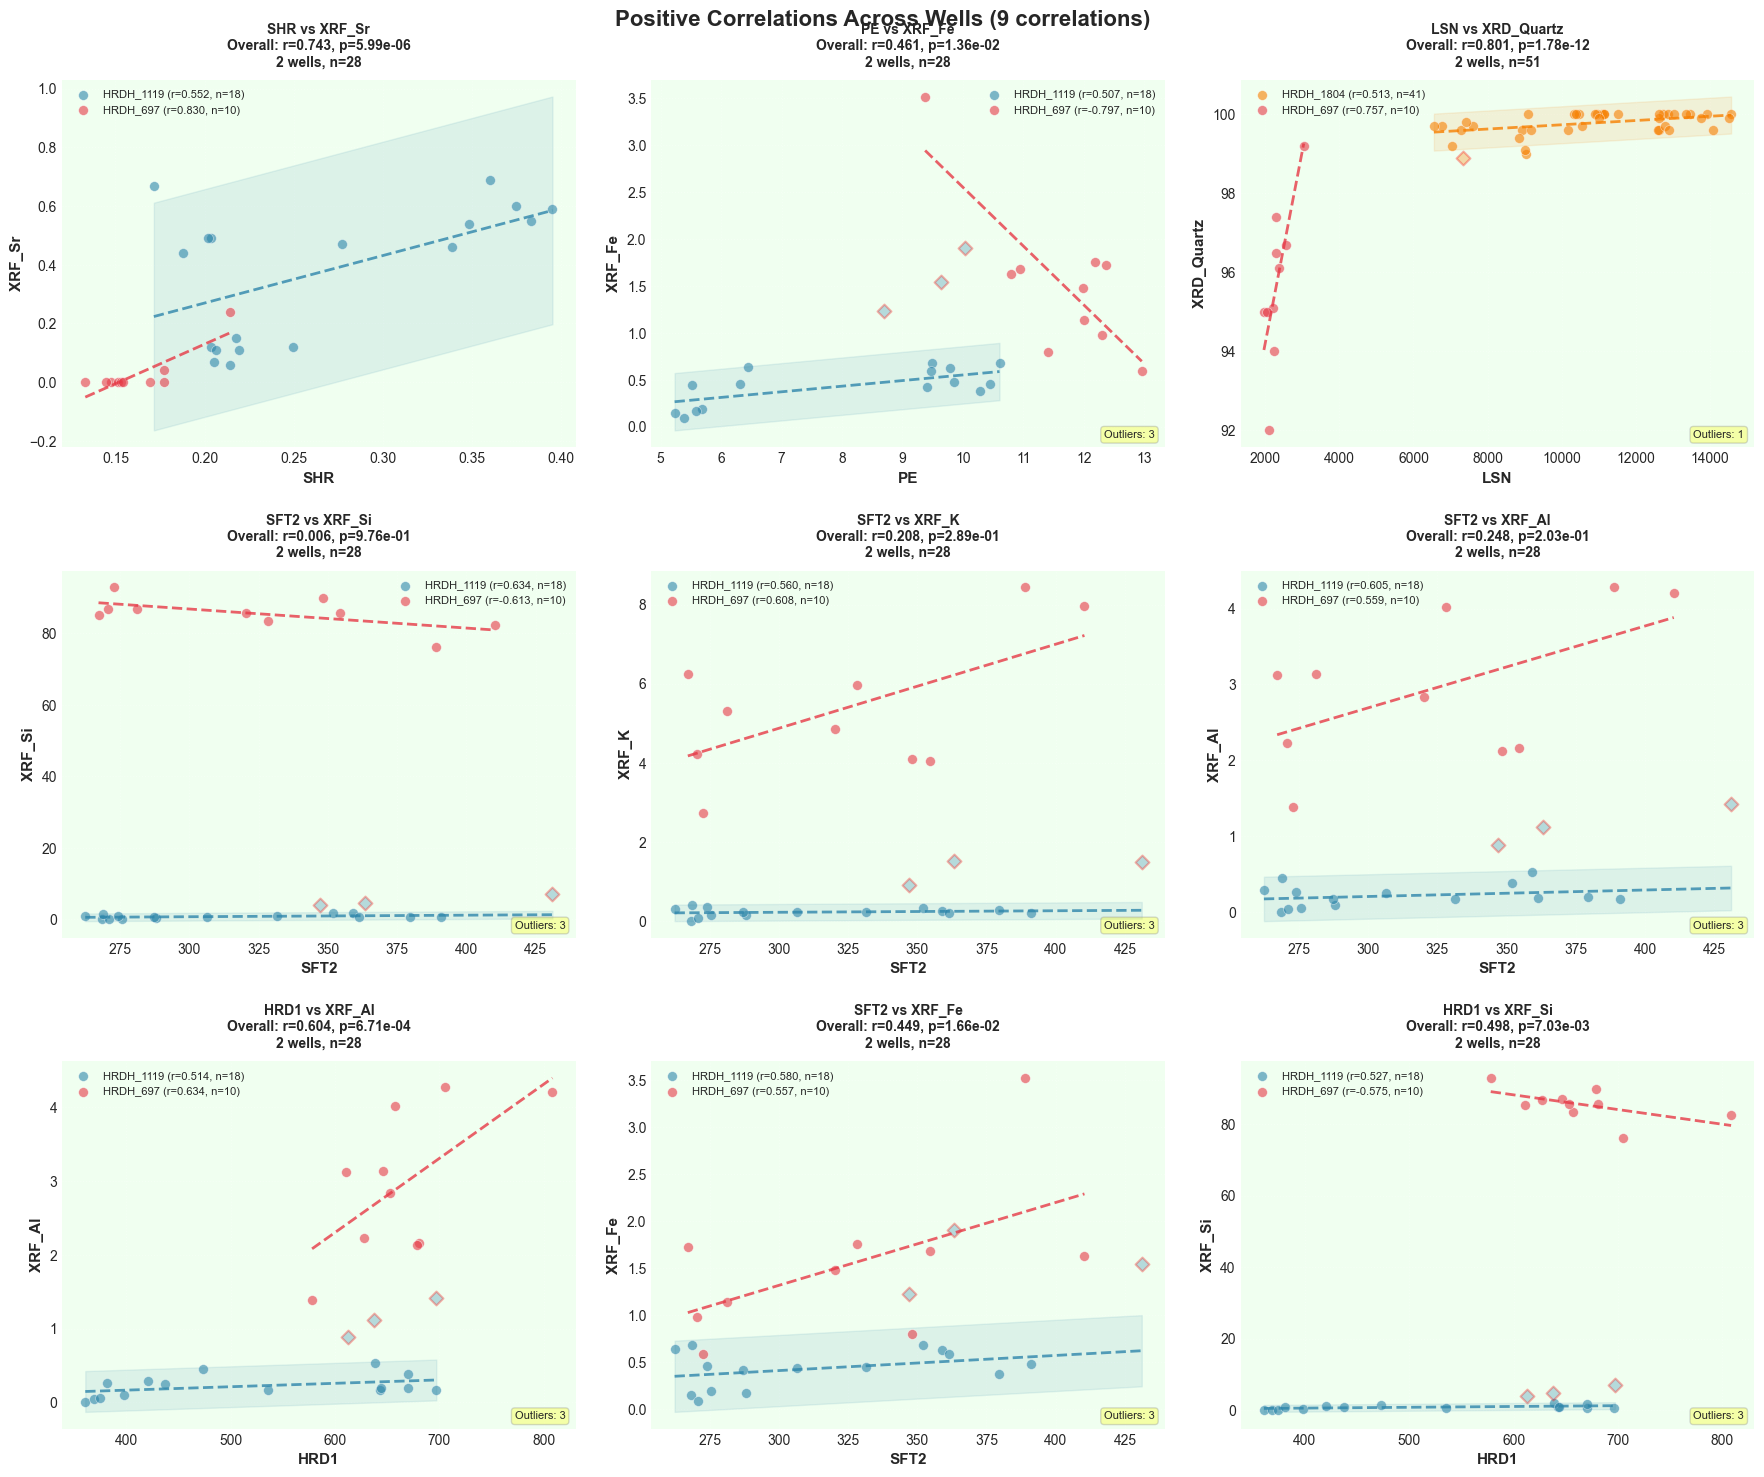


Creating plot for 6 NEGATIVE correlations...


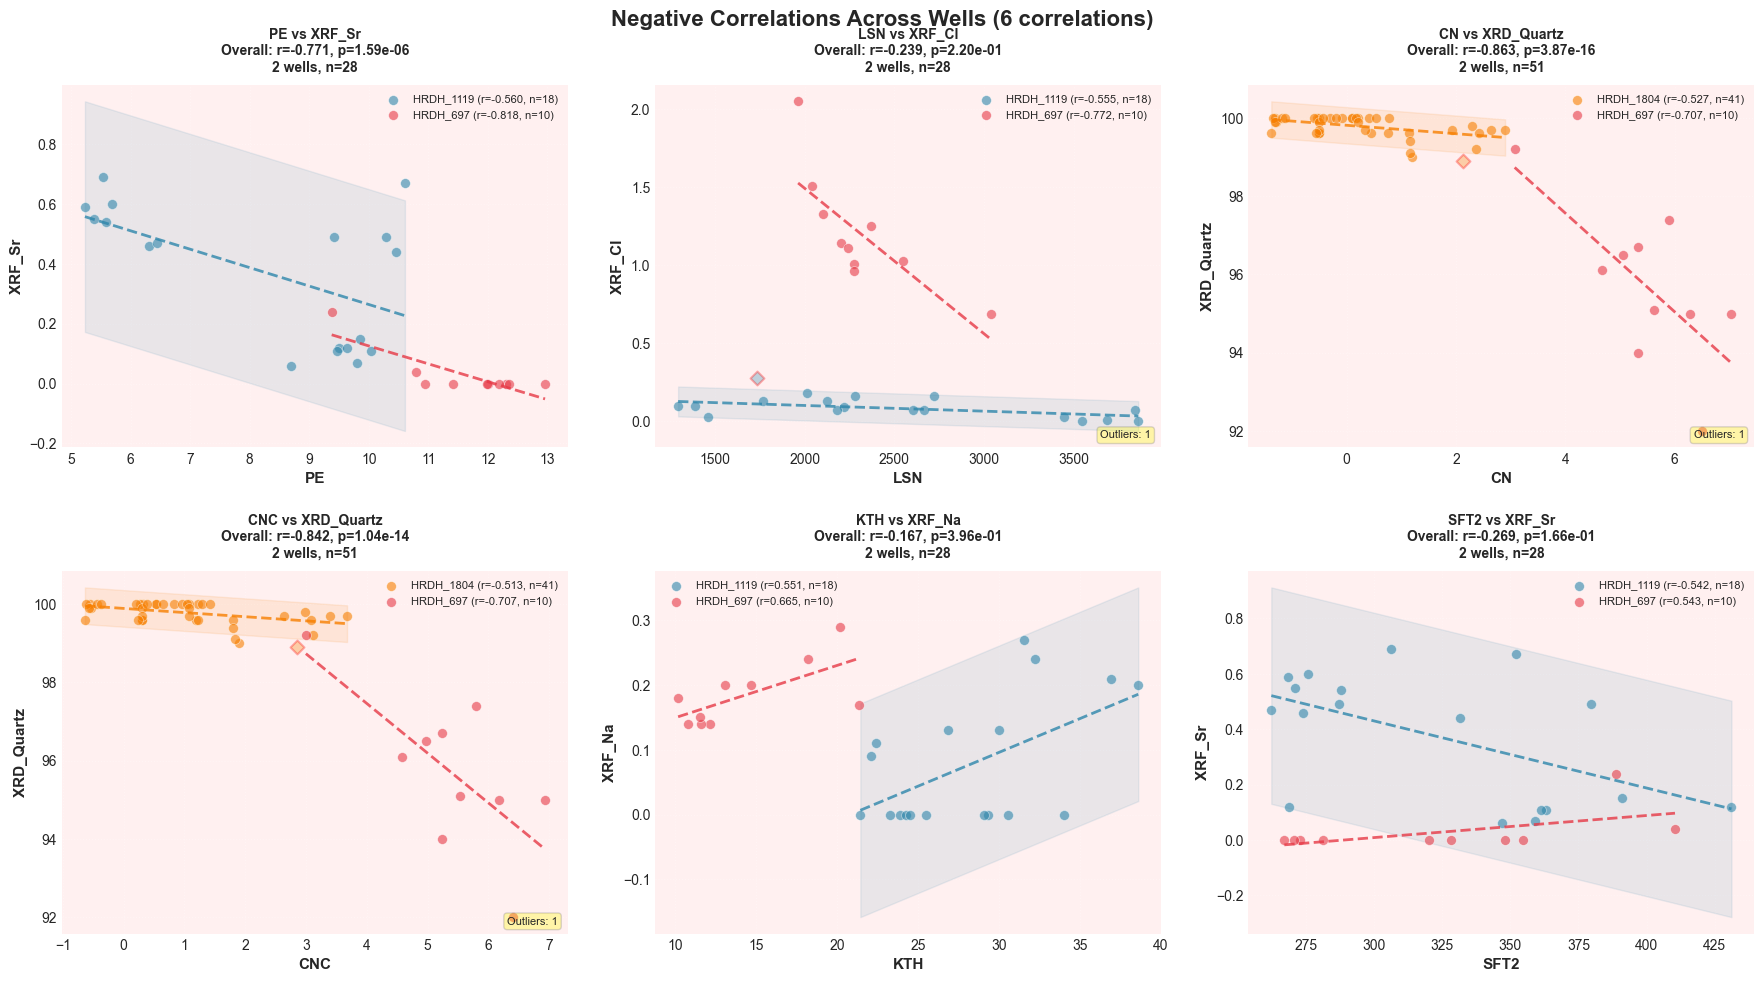


Saving 15 individual plots...

✅ Enhanced scatter plots created successfully!
   - Plots saved to: imgs/scatter_plots/
   - Individual plots saved to: imgs/scatter_plots\individual/

Outlier Summary:
   - LSN vs XRF_Cl: 1 outliers detected
   - PE vs XRF_Fe: 3 outliers detected
   - LSN vs XRD_Quartz: 1 outliers detected
   - SFT2 vs XRF_Si: 3 outliers detected
   - CN vs XRD_Quartz: 1 outliers detected
   - CNC vs XRD_Quartz: 1 outliers detected
   - SFT2 vs XRF_K: 3 outliers detected
   - SFT2 vs XRF_Al: 3 outliers detected
   - HRD1 vs XRF_Al: 3 outliers detected
   - SFT2 vs XRF_Fe: 3 outliers detected
   - HRD1 vs XRF_Si: 3 outliers detected

✅ Enhanced scatter plots created successfully!
   - Plots saved to: imgs/scatter_plots/
   - Individual plots saved to: imgs/scatter_plots\individual/

Outlier Summary:
   - LSN vs XRF_Cl: 1 outliers detected
   - PE vs XRF_Fe: 3 outliers detected
   - LSN vs XRD_Quartz: 1 outliers detected
   - SFT2 vs XRF_Si: 3 outliers detected
   - CN vs

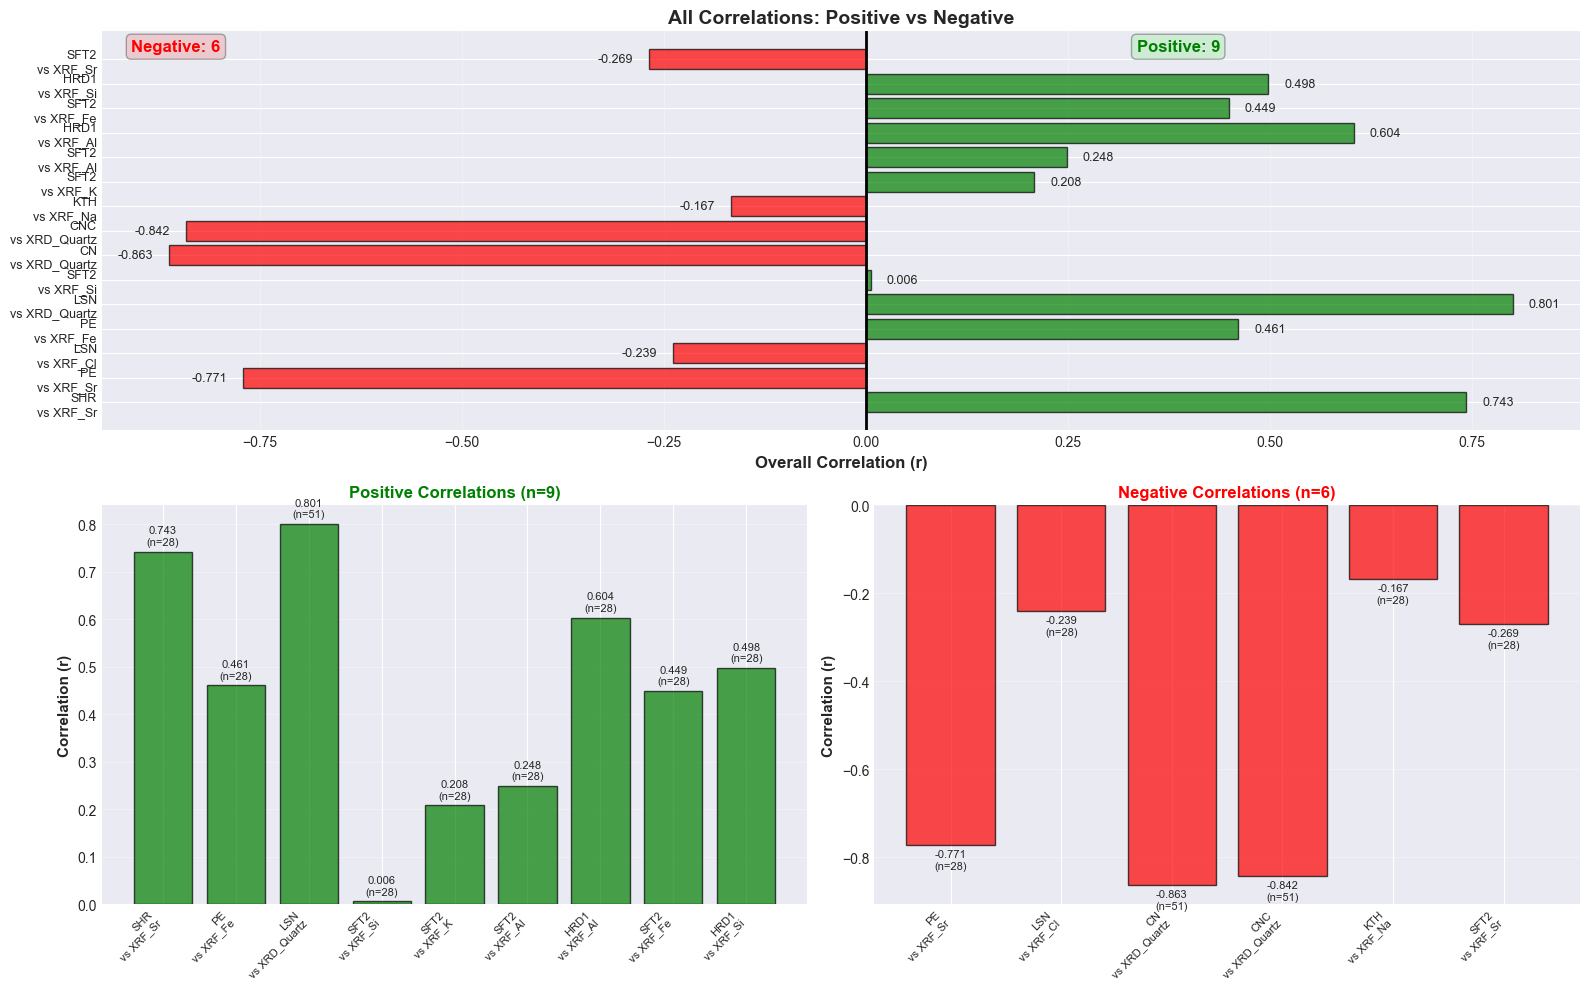

In [ ]:
# Replace the existing create_combined_scatter_plots function with the improved version
def create_combined_scatter_plots(common_correlations, df_all, top_n=15, 
                                 figsize_per_plot=(6, 5), max_cols=3,
                                 save_individual=True, show_outliers=True,
                                 add_trend_lines=True, add_confidence_intervals=True,
                                 separate_by_sign=True):
    """
    Create enhanced combined scatter plots for the top common correlations.
    
    Parameters:
    -----------
    common_correlations : list
        List of common correlations from find_common_correlations
    df_all : DataFrame
        Combined data from all wells
    top_n : int
        Number of top correlations to plot
    figsize_per_plot : tuple
        Size of each subplot (width, height)
    max_cols : int
        Maximum number of columns in the grid
    save_individual : bool
        Whether to save each plot individually
    show_outliers : bool
        Whether to highlight outliers
    add_trend_lines : bool
        Whether to add regression lines for each well
    add_confidence_intervals : bool
        Whether to add confidence intervals to regression lines
    separate_by_sign : bool
        Whether to create separate plots for positive and negative correlations
    
    Returns:
    --------
    dict : Summary statistics for each plotted correlation
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    from scipy import stats
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms
    
    # Simple linear regression function using numpy
    def fit_linear_regression(x, y):
        """Simple linear regression using numpy instead of sklearn"""
        # Add intercept term
        X = np.column_stack([np.ones(len(x)), x])
        # Solve using least squares
        coeffs = np.linalg.lstsq(X, y, rcond=None)[0]
        intercept, slope = coeffs
        
        # Calculate predictions
        y_pred = slope * x + intercept
        
        # Calculate R-squared
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
        
        # Calculate MSE for confidence intervals
        mse = ss_res / (len(y) - 2) if len(y) > 2 else 0
        
        return slope, intercept, r2, mse
    
    def create_subplot_grid(plot_data_list, title_prefix, filename_prefix, background_color):
        """Create a subplot grid for a list of correlations"""
        if not plot_data_list:
            return None
            
        n_plots = len(plot_data_list)
        n_cols = min(max_cols, n_plots)
        n_rows = (n_plots + n_cols - 1) // n_cols
        
        # Create figure with subplots
        fig_width = figsize_per_plot[0] * n_cols
        fig_height = figsize_per_plot[1] * n_rows
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
        
        if n_plots == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes if isinstance(axes, np.ndarray) else [axes]
        else:
            axes = axes.flatten()
        
        # Plot each correlation
        for idx, plot_data in enumerate(plot_data_list):
            ax = axes[idx]
            
            # Plot data for each well
            for well, data in plot_data['well_data'].items():
                # Plot regular points
                regular_mask = ~data['outliers_mask']
                ax.scatter(data['log_vals'][regular_mask], 
                          data['lab_vals'][regular_mask], 
                          color=data['color'], 
                          alpha=0.6, s=50, 
                          label=f"{well} (r={data['correlation']:.3f}, n={data['n_points']})",
                          edgecolors='white', linewidth=0.5)
                
                # Plot outliers differently if requested
                if show_outliers and data['n_outliers'] > 0:
                    ax.scatter(data['log_vals'][data['outliers_mask']], 
                              data['lab_vals'][data['outliers_mask']], 
                              color=data['color'], 
                              alpha=0.3, s=50, 
                              marker='D',  # Diamond for outliers
                              edgecolors='red', linewidth=1.5)
                
                # Add trend line for each well if requested
                if add_trend_lines and len(data['log_vals']) > 3:
                    # Use data without outliers if outliers are detected
                    if show_outliers and data['n_outliers'] > 0:
                        x_clean = data['log_vals'][regular_mask]
                        y_clean = data['lab_vals'][regular_mask]
                    else:
                        x_clean = data['log_vals']
                        y_clean = data['lab_vals']
                    
                    if len(x_clean) > 3:
                        # Fit linear regression using our custom function
                        slope, intercept, r2, mse = fit_linear_regression(x_clean, y_clean)
                        
                        # Create smooth line
                        x_range = np.linspace(data['log_vals'].min(), data['log_vals'].max(), 100)
                        y_pred = slope * x_range + intercept
                        
                        ax.plot(x_range, y_pred, color=data['color'], 
                               linewidth=2, alpha=0.8, linestyle='--')
                        
                        # Add confidence interval if requested
                        if add_confidence_intervals and len(x_clean) > 10 and mse > 0:
                            # Simple confidence interval estimation
                            std_error = np.sqrt(mse)
                            confidence = 1.96 * std_error  # 95% confidence interval
                            
                            ax.fill_between(x_range, 
                                          y_pred - confidence, 
                                          y_pred + confidence,
                                          color=data['color'], 
                                          alpha=0.1)
            
            # Customize plot
            ax.set_xlabel(plot_data['log_var'].replace('Log_', ''), fontsize=11, fontweight='bold')
            ax.set_ylabel(plot_data['lab_var'].replace('Lab_', ''), fontsize=11, fontweight='bold')
            
            # Enhanced title with more information
            title_lines = [
                f"{plot_data['title']}",
                f"Overall: r={plot_data.get('overall_r', np.nan):.3f}, p={plot_data.get('overall_p', np.nan):.2e}",
                f"{plot_data['wells_count']} wells, n={plot_data.get('n_total_points', 0)}"
            ]
            ax.set_title('\n'.join(title_lines), fontsize=10, fontweight='bold', pad=10)
            
            # Enhanced legend
            legend = ax.legend(fontsize=8, loc='best', framealpha=0.9, 
                              edgecolor='gray', fancybox=True, shadow=True)
            
            # Add grid with custom style
            ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
            ax.set_axisbelow(True)
            
            # Set background color
            ax.set_facecolor(background_color)
            
            # Add text box with additional statistics
            stats_text = []
            if show_outliers:
                total_outliers = sum(data['n_outliers'] for data in plot_data['well_data'].values())
                if total_outliers > 0:
                    stats_text.append(f"Outliers: {total_outliers}")
            
            if stats_text:
                ax.text(0.98, 0.02, '\n'.join(stats_text), transform=ax.transAxes,
                       fontsize=8, verticalalignment='bottom', horizontalalignment='right',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', 
                                alpha=0.3, edgecolor='gray'))
        
        # Hide empty subplots
        for idx in range(len(plot_data_list), len(axes)):
            axes[idx].set_visible(False)
        
        # Adjust layout and save
        plt.tight_layout(pad=2.0)
        
        # Add overall title to the figure
        fig.suptitle(f'{title_prefix} ({len(plot_data_list)} correlations)', 
                    fontsize=16, fontweight='bold', y=0.99)
        
        # Save combined plot
        plt.savefig(f'{output_dir}/{filename_prefix}_correlations_top_{len(plot_data_list)}.png', 
                    dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        
        return fig
    
    # Create output directories
    output_dir = 'imgs/scatter_plots'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    if save_individual:
        individual_dir = os.path.join(output_dir, 'individual')
        if not os.path.exists(individual_dir):
            os.makedirs(individual_dir)
    
    # Get list of all wells
    all_wells = sorted(df_all['Well'].unique())
    
    # Define distinct colors for wells with better color palette
    well_colors_fixed = {
        'HRDH_697': '#E63946',    # Red
        'HRDH_1119': '#2E86AB',   # Blue
        'HRDH_1804': '#F77F00',   # Orange
        'HRDH_1867': '#06D6A0',   # Teal
    }
    
    # Print well color assignments
    print("Enhanced Scatter Plot Analysis")
    print("=" * 60)
    print("\nWell Color Assignments:")
    print("-" * 40)
    for well in all_wells:
        color = well_colors_fixed.get(well, '#999999')
        print(f"  {well:<15} : {color} ■")
    print("-" * 40)
    
    # Process correlations based on new format
    plot_data_list = []
    summary_stats = {}
    
    # Handle both old and new formats
    pairs_to_plot = []
    if isinstance(common_correlations[0], tuple) and len(common_correlations[0]) == 3:
        # New format: (pair, wells_data, info)
        pairs_to_plot = [(pair, wells_data) for pair, wells_data, info in common_correlations[:top_n]]
    else:
        # Old format: (pair, wells_data)
        pairs_to_plot = common_correlations[:top_n]
    
    for idx, (pair, wells_data) in enumerate(pairs_to_plot):
        log_var, lab_var = pair
        
        # Collect data for all wells
        plot_data = {
            'log_var': log_var,
            'lab_var': lab_var,
            'well_data': {},
            'title': f"{log_var.replace('Log_', '')} vs {lab_var.replace('Lab_', '')}",
            'wells_count': len(wells_data)
        }
        
        all_log_vals = []
        all_lab_vals = []
        
        for well, r in wells_data:
            well_df = df_all[df_all['Well'] == well]
            
            # Get valid data points
            valid_mask = (~pd.isna(well_df[log_var])) & (~pd.isna(well_df[lab_var]))
            
            if valid_mask.sum() > 0:
                log_vals = well_df.loc[valid_mask, log_var].values
                lab_vals = well_df.loc[valid_mask, lab_var].values
                
                # Identify outliers using IQR method
                outliers_mask = np.zeros(len(log_vals), dtype=bool)
                if show_outliers and len(log_vals) > 10:
                    q1_log, q3_log = np.percentile(log_vals, [25, 75])
                    q1_lab, q3_lab = np.percentile(lab_vals, [25, 75])
                    iqr_log = q3_log - q1_log
                    iqr_lab = q3_lab - q1_lab
                    
                    outliers_mask = ((log_vals < q1_log - 1.5*iqr_log) | 
                                   (log_vals > q3_log + 1.5*iqr_log) |
                                   (lab_vals < q1_lab - 1.5*iqr_lab) | 
                                   (lab_vals > q3_lab + 1.5*iqr_lab))
                
                plot_data['well_data'][well] = {
                    'log_vals': log_vals,
                    'lab_vals': lab_vals,
                    'correlation': r,
                    'n_points': len(log_vals),
                    'color': well_colors_fixed.get(well, '#999999'),
                    'outliers_mask': outliers_mask,
                    'n_outliers': np.sum(outliers_mask)
                }
                
                all_log_vals.extend(log_vals)
                all_lab_vals.extend(lab_vals)
        
        # Calculate overall statistics
        if len(all_log_vals) > 1:
            overall_r, overall_p = stats.pearsonr(all_log_vals, all_lab_vals)
            plot_data['overall_r'] = overall_r
            plot_data['overall_p'] = overall_p
            plot_data['n_total_points'] = len(all_log_vals)
            
            # Store summary statistics
            summary_stats[f"{log_var} vs {lab_var}"] = {
                'overall_r': overall_r,
                'overall_p': overall_p,
                'n_total_points': len(all_log_vals),
                'n_wells': len(plot_data['well_data']),
                'wells': list(plot_data['well_data'].keys())
            }
        
        plot_data_list.append(plot_data)
    
    # Separate positive and negative correlations if requested
    if separate_by_sign:
        positive_correlations = []
        negative_correlations = []
        
        for plot_data in plot_data_list:
            overall_r = plot_data.get('overall_r', 0)
            if overall_r >= 0:
                positive_correlations.append(plot_data)
            else:
                negative_correlations.append(plot_data)
        
        print(f"\nSeparating correlations by sign:")
        print(f"  - Positive correlations: {len(positive_correlations)}")
        print(f"  - Negative correlations: {len(negative_correlations)}")
        
        # Create separate plots
        if positive_correlations:
            print(f"\nCreating plot for {len(positive_correlations)} POSITIVE correlations...")
            create_subplot_grid(
                positive_correlations, 
                "Positive Correlations Across Wells", 
                "positive",
                '#F0FFF0'  # Light green background
            )
        
        if negative_correlations:
            print(f"\nCreating plot for {len(negative_correlations)} NEGATIVE correlations...")
            create_subplot_grid(
                negative_correlations, 
                "Negative Correlations Across Wells", 
                "negative",
                '#FFF0F0'  # Light red background
            )
    else:
        # Create single combined plot
        print(f"\nCreating combined plot with {len(plot_data_list)} correlations...")
        create_subplot_grid(
            plot_data_list, 
            "Combined Correlations Across Wells", 
            "combined",
            '#F8F8FF'  # Light gray background
        )
    
    # Save individual plots if requested
    if save_individual:
        print(f"\nSaving {len(plot_data_list)} individual plots...")
        for idx, plot_data in enumerate(plot_data_list):
            fig_individual = plt.figure(figsize=(8, 6))
            ax_individual = fig_individual.add_subplot(111)
            
            # Copy the plot to individual figure
            for well, data in plot_data['well_data'].items():
                regular_mask = ~data['outliers_mask']
                ax_individual.scatter(data['log_vals'][regular_mask], 
                                    data['lab_vals'][regular_mask], 
                                    color=data['color'], 
                                    alpha=0.6, s=60, 
                                    label=f"{well} (r={data['correlation']:.3f}, n={data['n_points']})",
                                    edgecolors='white', linewidth=0.5)
                
                if show_outliers and data['n_outliers'] > 0:
                    ax_individual.scatter(data['log_vals'][data['outliers_mask']], 
                                        data['lab_vals'][data['outliers_mask']], 
                                        color=data['color'], 
                                        alpha=0.3, s=60, 
                                        marker='D',
                                        edgecolors='red', linewidth=1.5,
                                        label=f"{well} outliers (n={data['n_outliers']})")
            
            ax_individual.set_xlabel(plot_data['log_var'].replace('Log_', ''), fontsize=12, fontweight='bold')
            ax_individual.set_ylabel(plot_data['lab_var'].replace('Lab_', ''), fontsize=12, fontweight='bold')
            
            title_lines = [
                f"{plot_data['title']}",
                f"Overall: r={plot_data.get('overall_r', np.nan):.3f}, p={plot_data.get('overall_p', np.nan):.2e}",
                f"{plot_data['wells_count']} wells, n={plot_data.get('n_total_points', 0)}"
            ]
            ax_individual.set_title('\n'.join(title_lines), fontsize=12, fontweight='bold', pad=15)
            ax_individual.legend(fontsize=10, loc='best', framealpha=0.9)
            ax_individual.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
            
            # Set background color based on correlation sign
            overall_r = plot_data.get('overall_r', 0)
            if overall_r >= 0:
                ax_individual.set_facecolor('#F0FFF0')  # Light green for positive
            else:
                ax_individual.set_facecolor('#FFF0F0')  # Light red for negative
            
            # Save individual plot
            sign_prefix = "pos" if overall_r >= 0 else "neg"
            filename = f"{idx+1:02d}_{sign_prefix}_{plot_data['log_var'].replace('Log_', '')}_{plot_data['lab_var'].replace('Lab_', '')}.png"
            fig_individual.savefig(os.path.join(individual_dir, filename), 
                                 dpi=300, bbox_inches='tight', facecolor='white')
            plt.close(fig_individual)
    
    # Print summary
    print(f"\n✅ Enhanced scatter plots created successfully!")
    print(f"   - Plots saved to: {output_dir}/")
    if save_individual:
        print(f"   - Individual plots saved to: {individual_dir}/")
    
    # Print outlier summary if applicable
    if show_outliers:
        print("\nOutlier Summary:")
        for plot_data in plot_data_list:
            total_outliers = sum(data['n_outliers'] for data in plot_data['well_data'].values())
            if total_outliers > 0:
                print(f"   - {plot_data['title']}: {total_outliers} outliers detected")
    
    return summary_stats

# Additional helper function for creating a correlation strength summary plot
def plot_correlation_strength_summary(summary_stats, output_dir='imgs/scatter_plots'):
    """
    Create a summary plot showing correlation strengths across all analyzed pairs,
    with separate sections for positive and negative correlations.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Extract data
    pairs = list(summary_stats.keys())
    correlations = [stats['overall_r'] for stats in summary_stats.values()]
    n_wells = [stats['n_wells'] for stats in summary_stats.values()]
    n_points = [stats['n_total_points'] for stats in summary_stats.values()]
    
    # Separate positive and negative correlations
    pos_indices = [i for i, r in enumerate(correlations) if r >= 0]
    neg_indices = [i for i, r in enumerate(correlations) if r < 0]
    
    # Create figure with separate subplots for positive and negative
    fig = plt.figure(figsize=(16, 10))
    
    # Plot 1: All correlations together
    ax1 = plt.subplot(2, 2, (1, 2))
    colors = ['green' if r > 0 else 'red' for r in correlations]
    bars = ax1.barh(range(len(pairs)), correlations, color=colors, alpha=0.7, edgecolor='black')
    
    # Add value labels
    for i, (bar, r) in enumerate(zip(bars, correlations)):
        ax1.text(r + (0.02 if r > 0 else -0.02), i, f'{r:.3f}', 
                va='center', ha='left' if r > 0 else 'right', fontsize=9)
    
    ax1.set_yticks(range(len(pairs)))
    ax1.set_yticklabels([p.replace('Log_', '').replace('Lab_', '').replace(' vs ', '\nvs ') 
                         for p in pairs], fontsize=9)
    ax1.set_xlabel('Overall Correlation (r)', fontsize=12, fontweight='bold')
    ax1.set_title('All Correlations: Positive vs Negative', fontsize=14, fontweight='bold')
    ax1.axvline(x=0, color='black', linewidth=2, linestyle='-')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Add text annotations for counts
    n_pos = len(pos_indices)
    n_neg = len(neg_indices)
    ax1.text(0.7, 0.95, f'Positive: {n_pos}', transform=ax1.transAxes, 
             fontsize=12, fontweight='bold', color='green',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.3))
    ax1.text(0.02, 0.95, f'Negative: {n_neg}', transform=ax1.transAxes, 
             fontsize=12, fontweight='bold', color='red',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.3))
    
    # Plot 2: Positive correlations details
    if pos_indices:
        ax2 = plt.subplot(2, 2, 3)
        pos_pairs = [pairs[i] for i in pos_indices]
        pos_corrs = [correlations[i] for i in pos_indices]
        pos_samples = [n_points[i] for i in pos_indices]
        
        bars2 = ax2.bar(range(len(pos_pairs)), pos_corrs, color='green', alpha=0.7, edgecolor='black')
        ax2.set_xticks(range(len(pos_pairs)))
        ax2.set_xticklabels([p.replace('Log_', '').replace('Lab_', '').replace(' vs ', '\nvs ') 
                            for p in pos_pairs], rotation=45, ha='right', fontsize=8)
        ax2.set_ylabel('Correlation (r)', fontsize=11, fontweight='bold')
        ax2.set_title(f'Positive Correlations (n={len(pos_pairs)})', fontsize=12, fontweight='bold', color='green')
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for i, (bar, r, n) in enumerate(zip(bars2, pos_corrs, pos_samples)):
            ax2.text(i, bar.get_height() + 0.01, f'{r:.3f}\n(n={n})', 
                    ha='center', va='bottom', fontsize=8)
    
    # Plot 3: Negative correlations details
    if neg_indices:
        ax3 = plt.subplot(2, 2, 4)
        neg_pairs = [pairs[i] for i in neg_indices]
        neg_corrs = [correlations[i] for i in neg_indices]
        neg_samples = [n_points[i] for i in neg_indices]
        
        bars3 = ax3.bar(range(len(neg_pairs)), neg_corrs, color='red', alpha=0.7, edgecolor='black')
        ax3.set_xticks(range(len(neg_pairs)))
        ax3.set_xticklabels([p.replace('Log_', '').replace('Lab_', '').replace(' vs ', '\nvs ') 
                            for p in neg_pairs], rotation=45, ha='right', fontsize=8)
        ax3.set_ylabel('Correlation (r)', fontsize=11, fontweight='bold')
        ax3.set_title(f'Negative Correlations (n={len(neg_pairs)})', fontsize=12, fontweight='bold', color='red')
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for i, (bar, r, n) in enumerate(zip(bars3, neg_corrs, neg_samples)):
            ax3.text(i, bar.get_height() - 0.01, f'{r:.3f}\n(n={n})', 
                    ha='center', va='top', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/correlation_strength_summary_separated.png', 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# Call the enhanced function with separation by sign
summary_stats = create_combined_scatter_plots(
    common_correlations, 
    df_all, 
    top_n=15,
    figsize_per_plot=(6, 5),
    max_cols=3,
    save_individual=True,
    show_outliers=True,
    add_trend_lines=True,
    add_confidence_intervals=True,
    separate_by_sign=True  
)

# Create enhanced correlation strength summary plot
if summary_stats:
    plot_correlation_strength_summary(summary_stats)




VISUALIZING 3+ WELL CORRELATIONS
Enhanced Scatter Plot Analysis

Well Color Assignments:
----------------------------------------
  HRDH_1119       : #2E86AB ■
  HRDH_1804       : #F77F00 ■
  HRDH_1867       : #06D6A0 ■
  HRDH_697        : #E63946 ■
----------------------------------------

Separating correlations by sign:
  - Positive correlations: 4
  - Negative correlations: 0

Creating plot for 4 POSITIVE correlations...


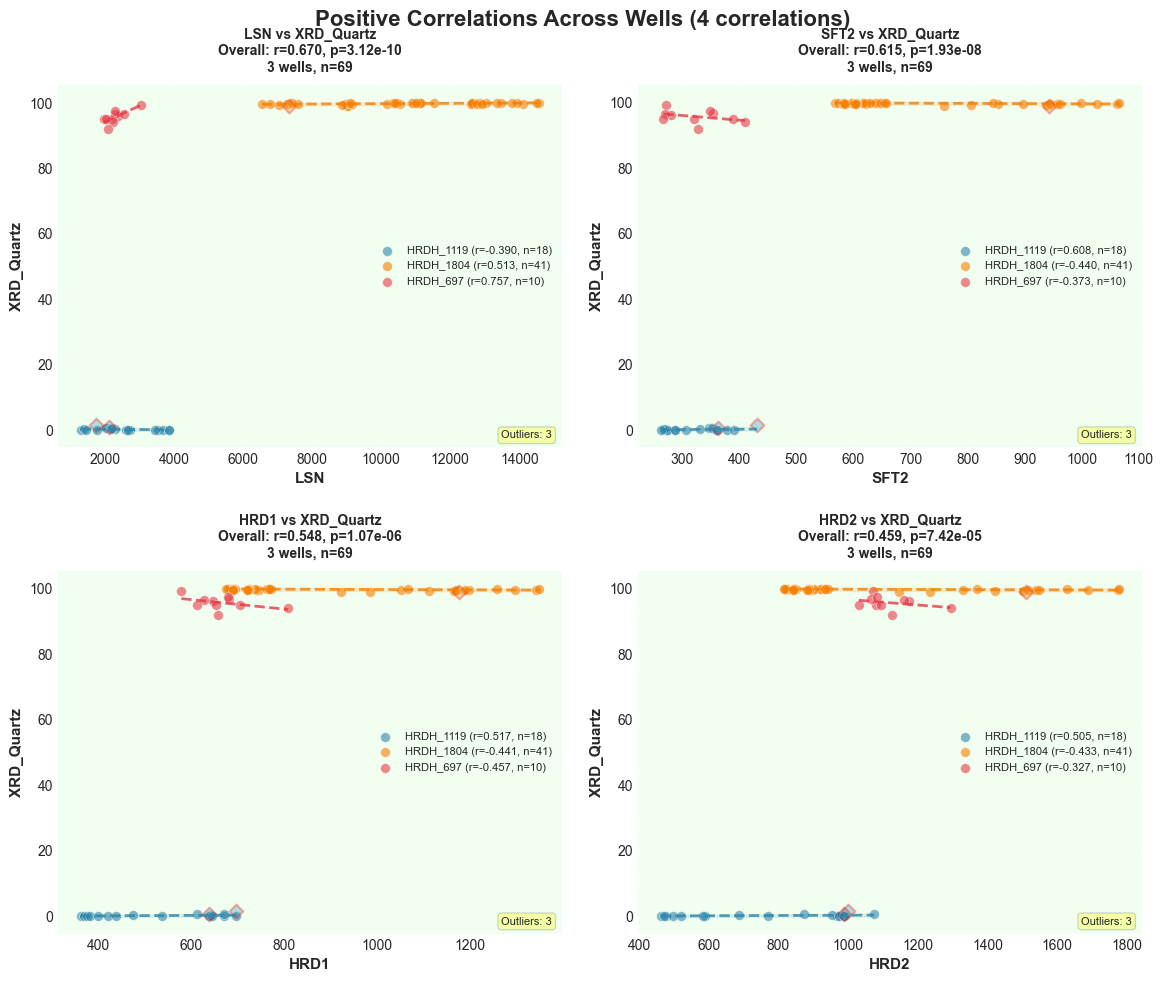


Saving 4 individual plots...

✅ Enhanced scatter plots created successfully!
   - Plots saved to: imgs/scatter_plots/
   - Individual plots saved to: imgs/scatter_plots\individual/

Outlier Summary:
   - LSN vs XRD_Quartz: 3 outliers detected
   - SFT2 vs XRD_Quartz: 3 outliers detected
   - HRD1 vs XRD_Quartz: 3 outliers detected
   - HRD2 vs XRD_Quartz: 3 outliers detected

Creating coverage heatmap for 3+ well correlations...

✅ Enhanced scatter plots created successfully!
   - Plots saved to: imgs/scatter_plots/
   - Individual plots saved to: imgs/scatter_plots\individual/

Outlier Summary:
   - LSN vs XRD_Quartz: 3 outliers detected
   - SFT2 vs XRD_Quartz: 3 outliers detected
   - HRD1 vs XRD_Quartz: 3 outliers detected
   - HRD2 vs XRD_Quartz: 3 outliers detected

Creating coverage heatmap for 3+ well correlations...


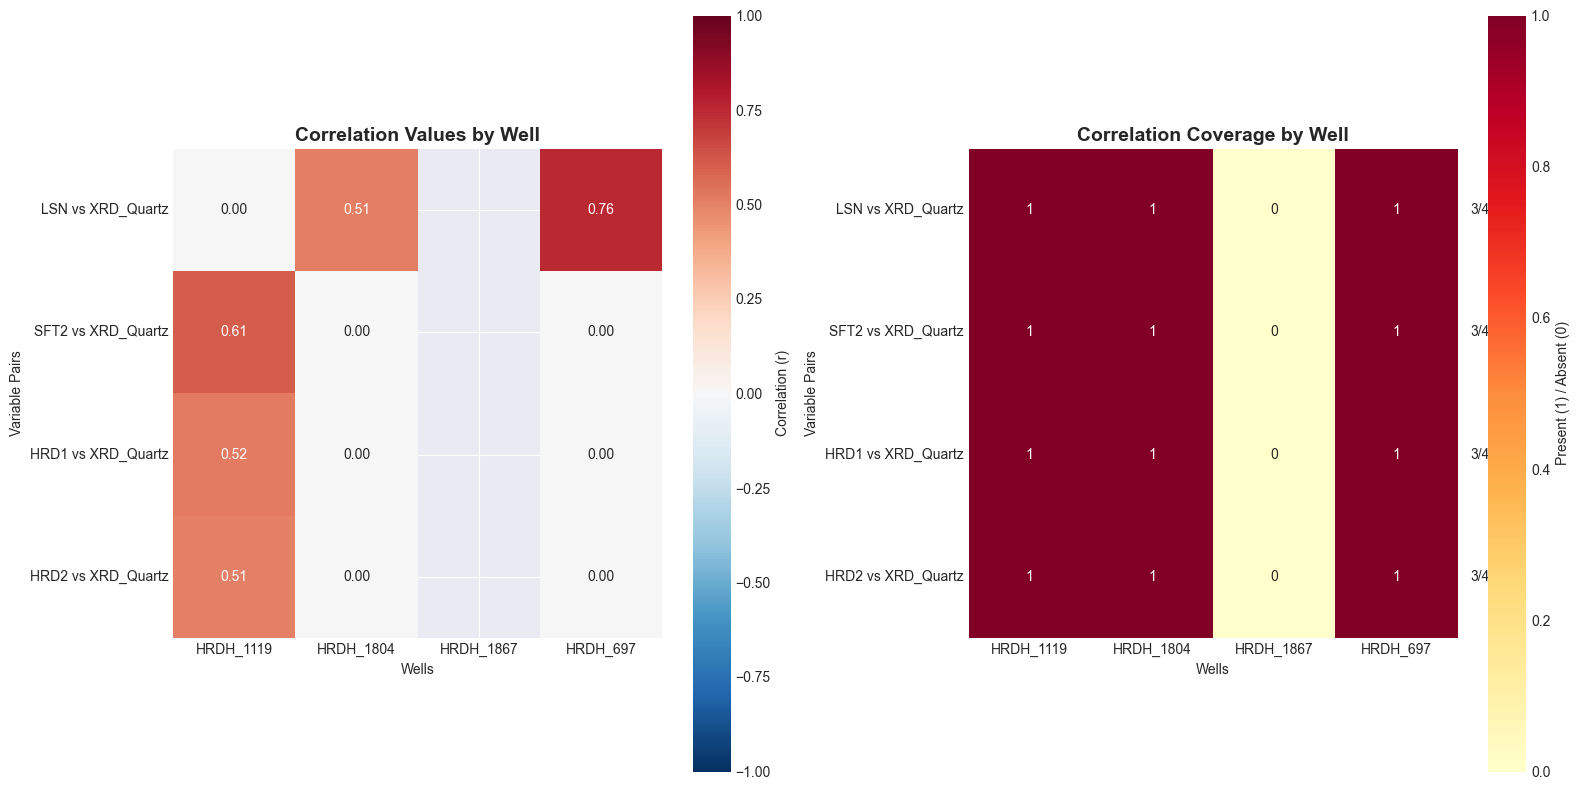


Analyzing distribution for 3+ well correlations...


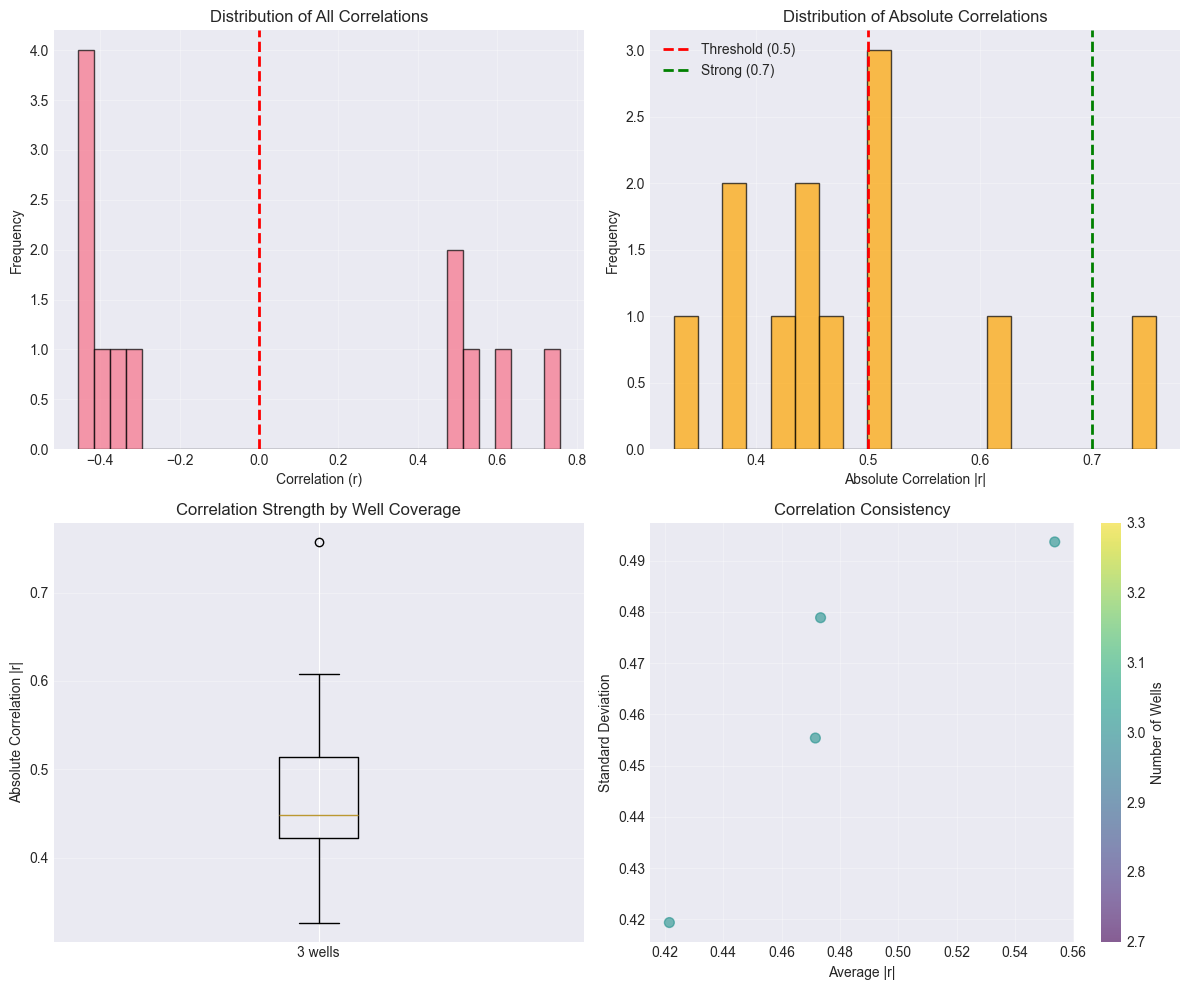


Correlation Distribution Statistics:
  - Total correlations: 12
  - Mean |r|: 0.480
  - Median |r|: 0.449
  - Std |r|: 0.110
  - Range: [-0.457, 0.757]


In [46]:
# Add this after finding common_correlations_3wells
if len(common_correlations_3wells) > 0:
    print("\n" + "="*60)
    print("VISUALIZING 3+ WELL CORRELATIONS")
    print("="*60)
    
    # Create scatter plots for 3+ well correlations
    summary_stats_3wells = create_combined_scatter_plots(
        common_correlations_3wells,  # <-- Use the 3-well correlations
        df_all, 
        top_n=len(common_correlations_3wells),  # Show all of them since there are only 4
        figsize_per_plot=(6, 5),
        max_cols=2,  # Fewer columns since there are fewer plots
        save_individual=True,
        show_outliers=True,
        add_trend_lines=True,
        add_confidence_intervals=True,
        separate_by_sign=True
    )
    
    # Create coverage heatmap specifically for 3+ well correlations
    print("\nCreating coverage heatmap for 3+ well correlations...")
    create_correlation_coverage_heatmap(common_correlations_3wells, well_correlations, 
                                       top_n=len(common_correlations_3wells))
    
    # Analyze distribution for 3+ well correlations
    print("\nAnalyzing distribution for 3+ well correlations...")
    analyze_correlation_distribution(common_correlations_3wells)

In [39]:
def create_correlation_coverage_heatmap(common_correlations, well_correlations, top_n=20):
    """
    Create a heatmap showing which correlations are present in which wells.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Get top correlations
    top_correlations = common_correlations[:top_n]
    
    # Create matrix
    all_wells = sorted(well_correlations.keys())
    matrix_data = []
    pair_labels = []
    
    for pair, _, info in top_correlations:
        log_var, lab_var = pair
        pair_label = f"{log_var.replace('Log_', '')} vs {lab_var.replace('Lab_', '')}"
        pair_labels.append(pair_label)
        
        row = []
        for well in all_wells:
            # Get correlation value for this well
            corr_matrix = well_correlations[well]
            r = corr_matrix.loc[log_var, lab_var]
            
            if pd.isna(r):
                row.append(np.nan)
            elif abs(r) >= 0.5:  # Using the threshold
                row.append(r)
            else:
                row.append(0)  # Below threshold
        
        matrix_data.append(row)
    
    # Create DataFrame
    coverage_df = pd.DataFrame(matrix_data, columns=all_wells, index=pair_labels)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, max(8, len(pair_labels)*0.4)))
    
    # Heatmap 1: Correlation values
    sns.heatmap(coverage_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, cbar_kws={'label': 'Correlation (r)'},
                ax=ax1, square=True)
    ax1.set_title('Correlation Values by Well', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Wells')
    ax1.set_ylabel('Variable Pairs')
    
    # Heatmap 2: Binary presence
    coverage_binary = coverage_df.notna().astype(int)
    sns.heatmap(coverage_binary, annot=True, fmt='d', cmap='YlOrRd',
                cbar_kws={'label': 'Present (1) / Absent (0)'},
                ax=ax2, square=True)
    ax2.set_title('Correlation Coverage by Well', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Wells')
    ax2.set_ylabel('Variable Pairs')
    
    # Add coverage summary to the right
    coverage_counts = coverage_binary.sum(axis=1)
    for i, (pair_label, count) in enumerate(coverage_counts.items()):
        ax2.text(len(all_wells) + 0.1, i + 0.5, f'{count}/{len(all_wells)}',
                ha='left', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('imgs/correlation_coverage_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_correlation_distribution(common_correlations):
    """
    Analyze and visualize the distribution of correlation strengths.
    """
    import matplotlib.pyplot as plt
    
    # Extract all correlation values
    all_correlations = []
    for _, wells_data, _ in common_correlations:
        for _, r in wells_data:
            all_correlations.append(r)
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Histogram of all correlations
    ax1 = axes[0, 0]
    ax1.hist(all_correlations, bins=30, edgecolor='black', alpha=0.7)
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('Correlation (r)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of All Correlations')
    ax1.grid(True, alpha=0.3)
    
    # 2. Histogram of absolute correlations
    ax2 = axes[0, 1]
    abs_correlations = [abs(r) for r in all_correlations]
    ax2.hist(abs_correlations, bins=20, edgecolor='black', alpha=0.7, color='orange')
    ax2.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
    ax2.axvline(x=0.7, color='green', linestyle='--', linewidth=2, label='Strong (0.7)')
    ax2.set_xlabel('Absolute Correlation |r|')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Absolute Correlations')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Box plot by number of wells
    ax3 = axes[1, 0]
    data_by_wells = {}
    for _, wells_data, info in common_correlations:
        n_wells = info['n_wells']
        if n_wells not in data_by_wells:
            data_by_wells[n_wells] = []
        data_by_wells[n_wells].extend([abs(r) for _, r in wells_data])
    
    box_data = [data_by_wells[n] for n in sorted(data_by_wells.keys())]
    box_labels = [f'{n} wells' for n in sorted(data_by_wells.keys())]
    
    ax3.boxplot(box_data, labels=box_labels)
    ax3.set_ylabel('Absolute Correlation |r|')
    ax3.set_title('Correlation Strength by Well Coverage')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Scatter plot: Average correlation vs Standard deviation
    ax4 = axes[1, 1]
    avg_corrs = [info['avg_abs_corr'] for _, _, info in common_correlations]
    std_corrs = [info['std_corr'] for _, _, info in common_correlations]
    n_wells = [info['n_wells'] for _, _, info in common_correlations]
    
    scatter = ax4.scatter(avg_corrs, std_corrs, c=n_wells, s=50, alpha=0.6, cmap='viridis')
    ax4.set_xlabel('Average |r|')
    ax4.set_ylabel('Standard Deviation')
    ax4.set_title('Correlation Consistency')
    ax4.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Number of Wells')
    
    plt.tight_layout()
    plt.savefig('imgs/correlation_distribution_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nCorrelation Distribution Statistics:")
    print(f"  - Total correlations: {len(all_correlations)}")
    print(f"  - Mean |r|: {np.mean(abs_correlations):.3f}")
    print(f"  - Median |r|: {np.median(abs_correlations):.3f}")
    print(f"  - Std |r|: {np.std(abs_correlations):.3f}")
    print(f"  - Range: [{min(all_correlations):.3f}, {max(all_correlations):.3f}]")

def check_data_distribution(df, log_var, lab_var):
    """Check data distribution and identify potential outliers"""
    
    data = df[[log_var, lab_var, 'Well']].dropna()
    
    print(f"\nData distribution for {log_var} vs {lab_var}:")
    print(f"Total samples: {len(data)}")
    
    # Basic statistics
    print(f"\n{log_var} statistics:")
    print(data[log_var].describe())
    
    print(f"\n{lab_var} statistics:")
    print(data[lab_var].describe())
    
    # Check for potential outliers
    for var in [log_var, lab_var]:
        q1, q3 = data[var].quantile([0.25, 0.75])
        iqr = q3 - q1
        outliers = data[(data[var] < q1 - 1.5*iqr) | (data[var] > q3 + 1.5*iqr)]
        
        if len(outliers) > 0:
            print(f"\nPotential outliers in {var}: {len(outliers)} samples")
            print(f"Outlier range: [{outliers[var].min():.2f}, {outliers[var].max():.2f}]")
            print(f"Normal range: [{q1 - 1.5*iqr:.2f}, {q3 + 1.5*iqr:.2f}]")

# Correlation Consistency Analysis


In [40]:
def analyze_correlation_consistency(common_correlations, well_correlations):
    """Analyze how consistent correlations are across wells"""
    
    consistency_data = []
    
    for pair, wells_data in common_correlations[:20]:  # Top 20 pairs
        log_var, lab_var = pair
        
        # Get correlations from all wells
        all_well_corrs = []
        for well, corr_matrix in well_correlations.items():
            r = corr_matrix.loc[log_var, lab_var]
            if not pd.isna(r):
                all_well_corrs.append(r)
        
        if len(all_well_corrs) >= 2:
            consistency_data.append({
                'Variable_Pair': f'{log_var.replace("Log_", "")} vs {lab_var.replace("Lab_", "")}',
                'Mean_r': np.mean(all_well_corrs),
                'Std_r': np.std(all_well_corrs),
                'Min_r': np.min(all_well_corrs),
                'Max_r': np.max(all_well_corrs),
                'Range_r': np.max(all_well_corrs) - np.min(all_well_corrs),
                'N_Wells': len(all_well_corrs)
            })
    
    consistency_df = pd.DataFrame(consistency_data)
    consistency_df = consistency_df.sort_values('Std_r')
    
    return consistency_df

# Analyze consistency
consistency_df = analyze_correlation_consistency(common_correlations, well_correlations)

print("Correlation Consistency Analysis (Top 10 most consistent):")
print(consistency_df.head(10).to_string(index=False, float_format='%.3f'))

Correlation Consistency Analysis (Top 10 most consistent):
    Variable_Pair  Mean_r  Std_r  Min_r  Max_r  Range_r  N_Wells
   SFT2 vs XRF_Fe   0.568  0.011  0.557  0.580    0.023        2
   SFT2 vs XRF_Al   0.582  0.023  0.559  0.605    0.046        2
    SFT2 vs XRF_K   0.584  0.024  0.560  0.608    0.049        2
    KTH vs XRF_Na   0.608  0.057  0.551  0.665    0.113        2
   HRD1 vs XRF_Al   0.574  0.060  0.514  0.634    0.119        2
    LSN vs XRF_Cl  -0.663  0.108 -0.772 -0.555    0.217        2
     PE vs XRF_Sr  -0.689  0.129 -0.818 -0.560    0.258        2
    SHR vs XRF_Sr   0.691  0.139  0.552  0.830    0.278        2
 CN vs XRD_Quartz  -0.332  0.410 -0.707  0.238    0.945        3
CNC vs XRD_Quartz  -0.325  0.411 -0.707  0.245    0.952        3


# Visualize correlation consistency


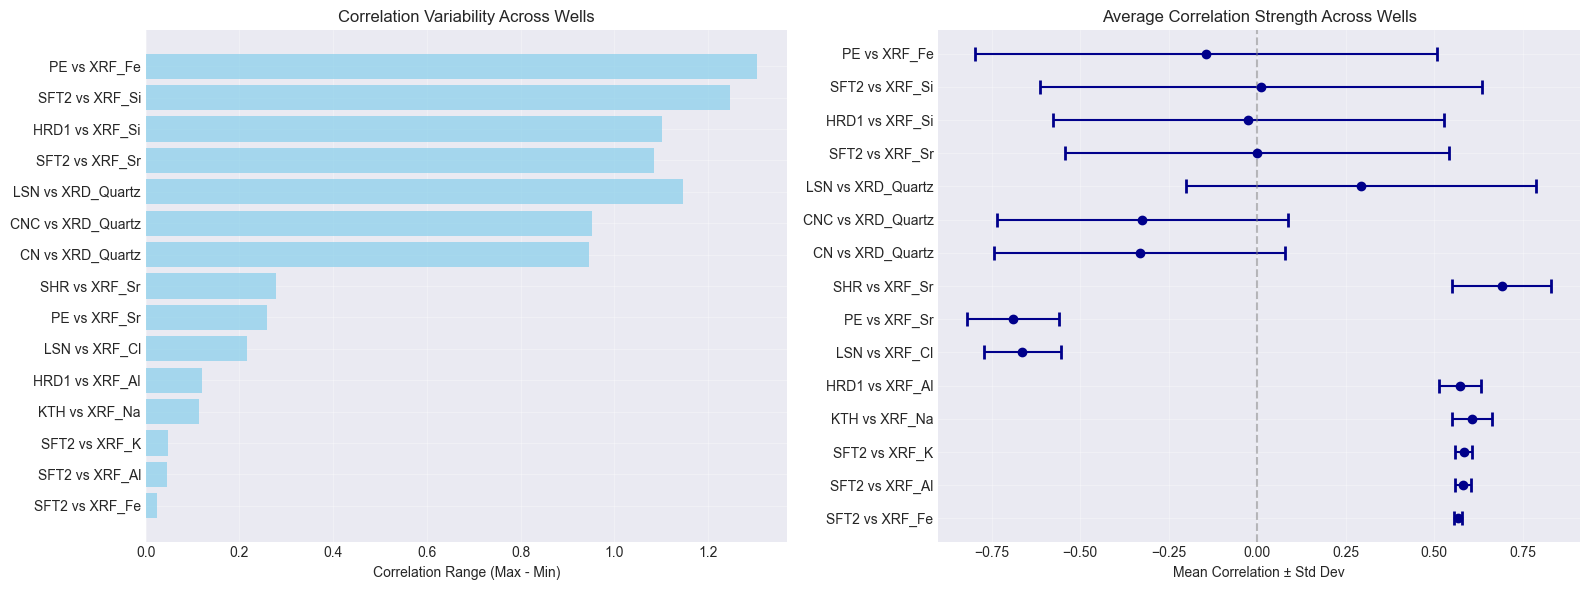

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Correlation ranges
y_pos = np.arange(len(consistency_df.head(15)))
ax1.barh(y_pos, consistency_df.head(15)['Range_r'], alpha=0.7, color='skyblue')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(consistency_df.head(15)['Variable_Pair'])
ax1.set_xlabel('Correlation Range (Max - Min)')
ax1.set_title('Correlation Variability Across Wells')
ax1.grid(True, alpha=0.3)

# Plot 2: Mean correlation with error bars
ax2.errorbar(consistency_df.head(15)['Mean_r'], y_pos, 
             xerr=consistency_df.head(15)['Std_r'],
             fmt='o', capsize=5, capthick=2, color='darkblue')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(consistency_df.head(15)['Variable_Pair'])
ax2.set_xlabel('Mean Correlation ± Std Dev')
ax2.set_title('Average Correlation Strength Across Wells')
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('imgs/correlation_consistency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 9. Summary Statistics and Export


In [42]:
# Create summary report
print("=" * 80)
print("COMBINED WELL ANALYSIS SUMMARY")
print("=" * 80)
print(f"\nDataset Overview:")
print(f"  - Total samples: {len(df_all):,}")
print(f"  - Number of wells: {df_all['Well'].nunique()}")
print(f"  - Lab variables: {len(lab_columns)}")
print(f"  - Log variables: {len(log_columns)}")

print(f"\nData Quality:")
print(f"  - Overall completeness: {(1 - df_all.isnull().sum().sum() / (len(df_all) * len(df_all.columns))) * 100:.1f}%")
print(f"  - Columns with >50% missing: {len(high_missing)}")

print(f"\nCorrelation Analysis:")
print(f"  - Variable pairs with |r| ≥ 0.5 in ≥2 wells: {len(common_correlations)}")
print(f"  - Most consistent correlation: {consistency_df.iloc[0]['Variable_Pair']} (σ = {consistency_df.iloc[0]['Std_r']:.3f})")
print(f"  - Strongest average correlation: {consistency_df.loc[consistency_df['Mean_r'].abs().idxmax(), 'Variable_Pair']} (r̄ = {consistency_df.loc[consistency_df['Mean_r'].abs().idxmax(), 'Mean_r']:.3f})")

COMBINED WELL ANALYSIS SUMMARY

Dataset Overview:
  - Total samples: 78
  - Number of wells: 4
  - Lab variables: 35
  - Log variables: 15

Data Quality:
  - Overall completeness: 68.3%
  - Columns with >50% missing: 33

Correlation Analysis:
  - Variable pairs with |r| ≥ 0.5 in ≥2 wells: 15
  - Most consistent correlation: SFT2 vs XRF_Fe (σ = 0.011)
  - Strongest average correlation: SHR vs XRF_Sr (r̄ = 0.691)


In [43]:
# Export results
# Save common correlations
common_corr_df = []
for pair, wells_data in common_correlations:
    log_var, lab_var = pair
    for well, r in wells_data:
        common_corr_df.append({
            'Log_Variable': log_var,
            'Lab_Variable': lab_var,
            'Well': well,
            'Correlation': r
        })

common_corr_df = pd.DataFrame(common_corr_df)
common_corr_df.to_csv('imgs/common_correlations_all_wells.csv', index=False)

# Save consistency analysis
consistency_df.to_csv('imgs/correlation_consistency_analysis.csv', index=False)

print("\n✅ Results exported to:")
print("  - imgs/common_correlations_all_wells.csv")
print("  - imgs/correlation_consistency_analysis.csv")


✅ Results exported to:
  - imgs/common_correlations_all_wells.csv
  - imgs/correlation_consistency_analysis.csv


# Additional Visualization Functions

These functions provide enhanced analysis and visualization of correlation patterns across wells.

In [44]:
def plot_correlation_matrix(df, variables, title='Correlation Matrix', cmap='coolwarm'):
    """
    Plot a correlation matrix for the given variables in the DataFrame.
    
    Parameters:
    -----------
    df : DataFrame
        The data containing the variables
    variables : list
        List of variable names to include in the correlation matrix
    title : str
        Title of the plot
    cmap : str
        Colormap to use for the heatmap
    
    Returns:
    --------
    None
    """
    import seaborn as sns
    
    # Calculate the correlation matrix
    corr = df[variables].corr()
    
    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap=cmap)
    
    # Title and labels
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

def plot_individual_well_correlations(df, well, log_vars, lab_vars):
    """
    Plot individual correlations for a specific well.
    
    Parameters:
    -----------
    df : DataFrame
        The data containing the variables
    well : str
        The well name to filter the data
    log_vars : list
        List of log variable names
    lab_vars : list
        List of lab variable names
    
    Returns:
    --------
    None
    """
    import matplotlib.pyplot as plt
    
    # Filter data for the specific well
    well_data = df[df['Well'] == well]
    
    # Set up the figure
    n_vars = len(log_vars) + len(lab_vars)
    fig, axes = plt.subplots(n_vars, 1, figsize=(10, 4*n_vars), sharex=True)
    
    # Plot each variable
    for i, var in enumerate(log_vars + lab_vars):
        ax = axes[i]
        
        # Scatter plot
        ax.scatter(well_data[var], well_data['Distance'], alpha=0.6)
        